In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import BallTree

import itertools

In [2]:


#Load shapefile with land uses
land_uses = gpd.read_file("buildings_w_section.shp")

#Sections gipuzkoa geojson
sections = gpd.read_file("sections_gipuzkoa.geojson")


#Load data from the csv file
#Indicators
ine = pd.read_excel("indicators.xlsx")

#Renta 
renta = pd.read_excel("renta_media_2022.xlsx")

#Import Biking data

dbizi_2021 = pd.read_csv("datos_2021.csv", encoding="ISO-8859-1", sep=";")
dbizi_2022 = pd.read_csv("datos_2022.csv", encoding="ISO-8859-1", sep=";")
#Ignore all accent marks in col names
dbizi_2021.columns = dbizi_2021.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
dbizi_2022.columns = dbizi_2022.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

#Merge the two years
dbizi = pd.concat([dbizi_2021, dbizi_2022])

#Stations 
stations = pd.read_csv("Stations_new.csv")


# Explore and prepare data

In [3]:
dbizi.head()

,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,Msnbc de bicicleta,Moto identificador publico,Modelo de bicicleta,Nombre de producto
0,561067,NORMAL,3229,45,31/12/2021 23:44,45 - XABIER LIZARDI,01/01/2022 0:38,44.0,44 - BERNARDO ESTORNES,10995,P32359,771.0,EFIT,Ordinario
1,561066,NORMAL,1384,6,31/12/2021 23:37,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,P32307,817.0,EFIT,Ocasional
2,561065,NORMAL,1452,6,31/12/2021 23:35,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,P32331,705.0,EFIT,Ocasional
3,561064,GRACE_PERIOD,29,6,31/12/2021 23:35,06 - ARRASATE,31/12/2021 23:36,6.0,06 - ARRASATE,13634,P32409,793.0,EFIT,Ocasional
4,561063,NORMAL,856,32,31/12/2021 23:31,32 - URBIA,31/12/2021 23:45,10.0,10 - PEÑA Y GOÑI,9877,P32390,777.0,EFIT,Ordinario


In [4]:
stations.head()

,ID,Nombre,Grupo,Total docks,Latitude,Longitude,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1.0,01 - UDALETXEA / AYUNTAMIENTO,NaN,23,43.321446,-1.986424,NaN,NaN,NaN
1,2.0,02 - BRETXA,NaN,15,43.322967,-1.982296,NaN,NaN,NaN
2,3.0,03 - SANTA KATALINA PLAZATXOA,NaN,15,43.321342,-1.980052,NaN,NaN,NaN
3,4.0,04 - ANDIA,NaN,23,43.320539,-1.982483,NaN,NaN,NaN
4,5.0,05 - SAN MARTZIAL,NaN,15,43.319301,-1.980584,NaN,NaN,NaN


In [5]:
#Rename dbizi rows that are  Nombre de estacion de inicio or Nombre de estacion de fin de viaje  23 - LEIRE PLAZA' to 23 - GABRIEL CELAYA PLAZA

dbizi.loc[dbizi['Nombre de estacion de inicio'] == "23 - LEIRE PLAZA", 'Nombre de estacion de inicio'] = "23 - GABRIEL CELAYA PLAZA"
dbizi.loc[dbizi['Nombre de estacion de fin de viaje'] == "23 - LEIRE PLAZA", 'Nombre de estacion de fin de viaje'] = "23 - GABRIEL CELAYA PLAZA"


In [6]:
# Merge the 'stations' data with 'dbizi' based on the matching station names
merged_dbizi = dbizi.merge(
    stations[["Nombre", "Latitude", "Longitude"]],
    left_on="Nombre de estacion de inicio",  # Matching column in dbizi
    right_on="Nombre",                       # Matching column in stations
    how="left"                               # Keep all rows from dbizi
)

# Rename the Latitude and Longitude columns
merged_dbizi = merged_dbizi.rename(columns={"Latitude": "start_lat", "Longitude": "start_lon"})

# Drop unnecessary duplicate 'Nombre' column if needed
merged_dbizi = merged_dbizi.drop(columns=["Nombre"])

# Result
print(merged_dbizi.head())

       ID Estado cerrado  Duracion  Id de estacion de inicio  \
0  561067         NORMAL      3229                        45   
1  561066         NORMAL      1384                         6   
2  561065         NORMAL      1452                         6   
3  561064   GRACE_PERIOD        29                         6   
4  561063         NORMAL       856                        32   

    Fecha de inicio Nombre de estacion de inicio      Fecha de fin  \
0  31/12/2021 23:44          45 - XABIER LIZARDI   01/01/2022 0:38   
1  31/12/2021 23:37                06 - ARRASATE   01/01/2022 0:00   
2  31/12/2021 23:35                06 - ARRASATE   01/01/2022 0:00   
3  31/12/2021 23:35                06 - ARRASATE  31/12/2021 23:36   
4  31/12/2021 23:31                   32 - URBIA  31/12/2021 23:45   

   Id de estacion de fin de viaje Nombre de estacion de fin de viaje  \
0                            44.0             44 - BERNARDO ESTORNES   
1                            47.0      01 - UDALET

In [7]:
merged_dbizi

,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,Msnbc de bicicleta,Moto identificador publico,Modelo de bicicleta,Nombre de producto,start_lat,start_lon
0,561067,NORMAL,3229,45,31/12/2021 23:44,45 - XABIER LIZARDI,01/01/2022 0:38,44.0,44 - BERNARDO ESTORNES,10995,P32359,771.0,EFIT,Ordinario,43.301378,-2.004624
1,561066,NORMAL,1384,6,31/12/2021 23:37,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,P32307,817.0,EFIT,Ocasional,43.318323,-1.981554
2,561065,NORMAL,1452,6,31/12/2021 23:35,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,P32331,705.0,EFIT,Ocasional,43.318323,-1.981554
3,561064,GRACE_PERIOD,29,6,31/12/2021 23:35,06 - ARRASATE,31/12/2021 23:36,6.0,06 - ARRASATE,13634,P32409,793.0,EFIT,Ocasional,43.318323,-1.981554
4,561063,NORMAL,856,32,31/12/2021 23:31,32 - URBIA,31/12/2021 23:45,10.0,10 - PEÑA Y GOÑI,9877,P32390,777.0,EFIT,Ordinario,43.310841,-1.967488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276237,561072,NORMAL,2153,19,01/01/2022 0:12,19 - FRANTZIA PASEALEKUA,01/01/2022 0:48,20.0,20 - TABAKALERA,1362,P15823,91.0,FIT,Ordinario (promoción 25%),43.317646,-1.977400
1276238,561071,NORMAL,860,32,01/01/2022 0:09,32 - URBIA,01/01/2022 0:24,7.0,07 - MARQUÉS MIRAFLORES,1929,P32344,789.0,EFIT,Ordinario Grupal,43.310841,-1.967488
1276239,561070,NORMAL,362,52,01/01/2022 0:09,23 - GABRIEL CELAYA PLAZA,01/01/2022 0:15,21.0,21 - KARMENGO ANDRE MARIA / VIRGEN DEL CARMEN,12958,P32386,740.0,EFIT,Ordinario,43.316641,-1.953469
1276240,561069,NORMAL,238,19,01/01/2022 0:08,19 - FRANTZIA PASEALEKUA,01/01/2022 0:12,15.0,15 - SEGUNDO IZPIZUA,7123,P32417,795.0,EFIT,Ordinario,43.317646,-1.977400


In [8]:
# Merge the 'stations' data with 'dbizi' based on the matching station names
dbizi_df = merged_dbizi.merge(
    stations[["Nombre", "Latitude", "Longitude"]],
    left_on="Nombre de estacion de fin de viaje",  # Matching column in dbizi
    right_on="Nombre",                       # Matching column in stations
    how="left"                               # Keep all rows from dbizi
)

# Rename the Latitude and Longitude columns
dbizi_df = dbizi_df.rename(columns={"Latitude": "end_lat", "Longitude": "end_lon"})

# Drop unnecessary duplicate 'Nombre' column if needed
dbizi_df = dbizi_df.drop(columns=["Nombre"])

# Result
print(dbizi_df.head())

       ID Estado cerrado  Duracion  Id de estacion de inicio  \
0  561067         NORMAL      3229                        45   
1  561066         NORMAL      1384                         6   
2  561065         NORMAL      1452                         6   
3  561064   GRACE_PERIOD        29                         6   
4  561063         NORMAL       856                        32   

    Fecha de inicio Nombre de estacion de inicio      Fecha de fin  \
0  31/12/2021 23:44          45 - XABIER LIZARDI   01/01/2022 0:38   
1  31/12/2021 23:37                06 - ARRASATE   01/01/2022 0:00   
2  31/12/2021 23:35                06 - ARRASATE   01/01/2022 0:00   
3  31/12/2021 23:35                06 - ARRASATE  31/12/2021 23:36   
4  31/12/2021 23:31                   32 - URBIA  31/12/2021 23:45   

   Id de estacion de fin de viaje Nombre de estacion de fin de viaje  \
0                            44.0             44 - BERNARDO ESTORNES   
1                            47.0      01 - UDALET

In [9]:
dbizi_df

,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,Msnbc de bicicleta,Moto identificador publico,Modelo de bicicleta,Nombre de producto,start_lat,start_lon,end_lat,end_lon
0,561067,NORMAL,3229,45,31/12/2021 23:44,45 - XABIER LIZARDI,01/01/2022 0:38,44.0,44 - BERNARDO ESTORNES,10995,P32359,771.0,EFIT,Ordinario,43.301378,-2.004624,43.303256,-2.007654
1,561066,NORMAL,1384,6,31/12/2021 23:37,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,P32307,817.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424
2,561065,NORMAL,1452,6,31/12/2021 23:35,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,P32331,705.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424
3,561064,GRACE_PERIOD,29,6,31/12/2021 23:35,06 - ARRASATE,31/12/2021 23:36,6.0,06 - ARRASATE,13634,P32409,793.0,EFIT,Ocasional,43.318323,-1.981554,43.318323,-1.981554
4,561063,NORMAL,856,32,31/12/2021 23:31,32 - URBIA,31/12/2021 23:45,10.0,10 - PEÑA Y GOÑI,9877,P32390,777.0,EFIT,Ordinario,43.310841,-1.967488,43.322780,-1.977272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276237,561072,NORMAL,2153,19,01/01/2022 0:12,19 - FRANTZIA PASEALEKUA,01/01/2022 0:48,20.0,20 - TABAKALERA,1362,P15823,91.0,FIT,Ordinario (promoción 25%),43.317646,-1.977400,43.317163,-1.974992
1276238,561071,NORMAL,860,32,01/01/2022 0:09,32 - URBIA,01/01/2022 0:24,7.0,07 - MARQUÉS MIRAFLORES,1929,P32344,789.0,EFIT,Ordinario Grupal,43.310841,-1.967488,43.317033,-1.986010
1276239,561070,NORMAL,362,52,01/01/2022 0:09,23 - GABRIEL CELAYA PLAZA,01/01/2022 0:15,21.0,21 - KARMENGO ANDRE MARIA / VIRGEN DEL CARMEN,12958,P32386,740.0,EFIT,Ordinario,43.316641,-1.953469,43.316996,-1.971482
1276240,561069,NORMAL,238,19,01/01/2022 0:08,19 - FRANTZIA PASEALEKUA,01/01/2022 0:12,15.0,15 - SEGUNDO IZPIZUA,7123,P32417,795.0,EFIT,Ordinario,43.317646,-1.977400,43.323948,-1.969948


In [10]:
# Land uses head

land_uses.head()

,Town,Referencia,Descripcio,Edificabil,Solar,Vivienda,Trastero,Garaje Cer,Agropecuar,Local Come,...,Duplex,Plaza Park,Religioso,Espectacul,index_righ,Seccion,NMUN,Renta_medi,Percentil,geometry
0,Andoain,7984046,None,0,0,267,92,0,188,0,...,0,0,0,0,8.0,2000901009,Andoain,15975.0,4,"POLYGON ((579409.327 4784688.273, 579409.547 4..."
1,Andoain,7984047,None,0,0,160,0,30,0,0,...,0,0,0,0,8.0,2000901009,Andoain,15975.0,4,"POLYGON ((579379.507 4784661.604, 579387.677 4..."
2,Andoain,7984013,None,0,0,108,153,108,0,0,...,0,0,0,0,8.0,2000901009,Andoain,15975.0,4,"POLYGON ((579380.339 4784743.544, 579384.819 4..."
3,Andoain,7984009,None,0,0,348,116,0,0,0,...,0,0,0,0,8.0,2000901009,Andoain,15975.0,4,"POLYGON ((579330.770 4784723.036, 579326.320 4..."
4,Andoain,7984010,None,0,0,360,108,0,0,0,...,0,0,0,0,8.0,2000901009,Andoain,15975.0,4,"POLYGON ((579342.980 4784760.725, 579358.430 4..."


In [11]:
#print Land uses cols
land_uses.columns

Index(['Town', 'Referencia', 'Descripcio', 'Edificabil', 'Solar', 'Vivienda',
       'Trastero', 'Garaje Cer', 'Agropecuar', 'Local Come', 'Industrial',
       'Almacen', 'Deportivo', 'Cultural', 'Educativo', 'Oficina',
       'Hosteleria', 'Obras Urba', 'Altura men', 'Terraza', 'Accesos y',
       'Jardin', 'Sanidad', 'Deposito', 'Duplex', 'Plaza Park', 'Religioso',
       'Espectacul', 'index_righ', 'Seccion', 'NMUN', 'Renta_medi',
       'Percentil', 'geometry'],
      dtype='object')

In [12]:
land_uses.shape

(43486, 34)

In [13]:
land_uses['Referencia'].nunique()

43484

In [14]:
#Save first 10 rows of land uses as a csv

land_uses.head(10).to_csv("land_uses_head.csv")

In [15]:
#Drop Descripcio, Referencia, NMUN, Percentil, geometry
land_uses = land_uses.drop(columns=['Descripcio', 'Referencia', 'NMUN', 'Percentil', 'geometry'])

#Group by Seccion and sum the cols
land_uses = land_uses.groupby("Seccion").sum()




In [16]:
land_uses.shape

(482, 28)

In [17]:
sections.head()

,CUSEC,CUMUN,Seccion,Distrito,CUDIS,Municipio,geometry
0,2000101001,20001,001,01,2000101,Abaltzisketa,"MULTIPOLYGON (((-2.09892 43.06533, -2.09890 43..."
1,2000201001,20002,001,01,2000201,Aduna,"MULTIPOLYGON (((-2.03912 43.20230, -2.03915 43..."
2,2000301001,20003,001,01,2000301,Aizarnazabal,"MULTIPOLYGON (((-2.20725 43.27294, -2.20714 43..."
3,2000401001,20004,001,01,2000401,Albiztur,"MULTIPOLYGON (((-2.11304 43.12570, -2.11322 43..."
4,2000501001,20005,001,01,2000501,Alegia,"MULTIPOLYGON (((-2.09007 43.11240, -2.08947 43..."


In [18]:
ine.head()

,Seccion,Municipio,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española
0,20001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5
1,2000101,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5
2,2000101001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5
3,20002,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2
4,2000201,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2


In [19]:
renta.head()

,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar
0,20001 Abaltzisketa,18661.0,51718.0,28504,26950,22222.0,61587.0
1,2000101 Abaltzisketa distrito 01,18661.0,51718.0,28504,26950,22222.0,61587.0
2,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0
3,20002 Aduna,17693.0,49640.0,27512,26250,21359.0,59925.0
4,2000201 Aduna distrito 01,17693.0,49640.0,27512,26250,21359.0,59925.0


In [20]:
renta.columns

Index([' ', 'Renta neta media por persona', 'Renta neta media por hogar',
       'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar'],
      dtype='object')

In [21]:
#Renta get the nums before the space
renta["Seccion"] = renta[" "].str.split(" ").str[0]

In [22]:
renta.head()

,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,Seccion
0,20001 Abaltzisketa,18661.0,51718.0,28504,26950,22222.0,61587.0,20001
1,2000101 Abaltzisketa distrito 01,18661.0,51718.0,28504,26950,22222.0,61587.0,2000101
2,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0,2000101001
3,20002 Aduna,17693.0,49640.0,27512,26250,21359.0,59925.0,20002
4,2000201 Aduna distrito 01,17693.0,49640.0,27512,26250,21359.0,59925.0,2000201


In [23]:
#Add a col with the number of numbers in Seccion
renta["num_seccion"] = renta["Seccion"].str.len()
renta.head()

,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,Seccion,num_seccion
0,20001 Abaltzisketa,18661.0,51718.0,28504,26950,22222.0,61587.0,20001,5.0
1,2000101 Abaltzisketa distrito 01,18661.0,51718.0,28504,26950,22222.0,61587.0,2000101,7.0
2,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0,2000101001,10.0
3,20002 Aduna,17693.0,49640.0,27512,26250,21359.0,59925.0,20002,5.0
4,2000201 Aduna distrito 01,17693.0,49640.0,27512,26250,21359.0,59925.0,2000201,7.0


In [24]:
#Num seccion value counts
renta["num_seccion"].value_counts()

num_seccion
10.0    548
7.0     121
5.0      89
6.0       1
2.0       1
3.0       1
9.0       1
Name: count, dtype: int64

In [25]:
#Drop rows with num_seccion different from 10
renta = renta[renta["num_seccion"] == 10]
renta.head()

,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,Seccion,num_seccion
2,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0,2000101001,10.0
5,2000201001 Aduna sección 01001,17693.0,49640.0,27512,26250,21359.0,59925.0,2000201001,10.0
8,2000301001 Aizarnazabal sección 01001,16215.0,41396.0,24634,24150,19258.0,49164.0,2000301001,10.0
11,2000401001 Albiztur sección 01001,17366.0,47033.0,27347,24850,20665.0,55967.0,2000401001,10.0
14,2000501001 Alegia sección 01001,15539.0,38209.0,22856,22050,18224.0,44813.0,2000501001,10.0


In [26]:
# Get the number of numbers in seccion
ine["num_seccion"] = ine["Seccion"].astype(str).str.len()
ine.head()



,Seccion,Municipio,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,num_seccion
0,20001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5,5
1,2000101,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5,7
2,2000101001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5,10
3,20002,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2,5
4,2000201,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2,7


In [27]:
#Drop rows with num_seccion different from 10
ine = ine[ine["num_seccion"] == 10]
ine.head()


,Seccion,Municipio,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,num_seccion
2,2000101001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5,10
5,2000201001,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2,10
8,2000301001,Aizarnazabal,40.7,24.0,18.2,2.6,28.1,776.0,94.6,10
11,2000401001,Albiztur,41.5,24.7,18.7,2.7,32.2,316.0,96.8,10
14,2000501001,Alegia,44.2,18.6,20.9,2.4,31.8,1729.0,88.9,10


# Merging data

In [28]:
ine["Seccion"] = ine["Seccion"].astype(str)
renta["Seccion"] = renta["Seccion"].astype(str)

In [29]:
#Merge renta and ine based on Seccion
merged_dem = ine.merge(renta, on="Seccion", how="left")
merged_dem.head()

,Seccion,Municipio,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,num_seccion_x,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,num_seccion_y
0,2000101001,Abaltzisketa,44.2,16.6,19.1,2.8,27.5,283.0,95.5,10,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0,10.0
1,2000201001,Aduna,39.8,24.1,15.0,2.8,26.6,486.0,99.2,10,2000201001 Aduna sección 01001,17693.0,49640.0,27512,26250,21359.0,59925.0,10.0
2,2000301001,Aizarnazabal,40.7,24.0,18.2,2.6,28.1,776.0,94.6,10,2000301001 Aizarnazabal sección 01001,16215.0,41396.0,24634,24150,19258.0,49164.0,10.0
3,2000401001,Albiztur,41.5,24.7,18.7,2.7,32.2,316.0,96.8,10,2000401001 Albiztur sección 01001,17366.0,47033.0,27347,24850,20665.0,55967.0,10.0
4,2000501001,Alegia,44.2,18.6,20.9,2.4,31.8,1729.0,88.9,10,2000501001 Alegia sección 01001,15539.0,38209.0,22856,22050,18224.0,44813.0,10.0


In [30]:
merged_dem.shape

(545, 18)

In [31]:
#Merge the merged_dem with sections based on Seccion

df_geo = sections.merge(merged_dem,left_on = 'CUSEC', right_on="Seccion", how="left")
df_geo.head()

,CUSEC,CUMUN,Seccion_x,Distrito,CUDIS,Municipio_x,geometry,Seccion_y,Municipio_y,Edad media de la población,...,Porcentaje de población española,num_seccion_x,,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,num_seccion_y
0,2000101001,20001,001,01,2000101,Abaltzisketa,"MULTIPOLYGON (((-2.09892 43.06533, -2.09890 43...",2000101001,Abaltzisketa,44.2,...,95.5,10.0,2000101001 Abaltzisketa sección 01001,18661.0,51718.0,28504,26950,22222.0,61587.0,10.0
1,2000201001,20002,001,01,2000201,Aduna,"MULTIPOLYGON (((-2.03912 43.20230, -2.03915 43...",2000201001,Aduna,39.8,...,99.2,10.0,2000201001 Aduna sección 01001,17693.0,49640.0,27512,26250,21359.0,59925.0,10.0
2,2000301001,20003,001,01,2000301,Aizarnazabal,"MULTIPOLYGON (((-2.20725 43.27294, -2.20714 43...",2000301001,Aizarnazabal,40.7,...,94.6,10.0,2000301001 Aizarnazabal sección 01001,16215.0,41396.0,24634,24150,19258.0,49164.0,10.0
3,2000401001,20004,001,01,2000401,Albiztur,"MULTIPOLYGON (((-2.11304 43.12570, -2.11322 43...",2000401001,Albiztur,41.5,...,96.8,10.0,2000401001 Albiztur sección 01001,17366.0,47033.0,27347,24850,20665.0,55967.0,10.0
4,2000501001,20005,001,01,2000501,Alegia,"MULTIPOLYGON (((-2.09007 43.11240, -2.08947 43...",2000501001,Alegia,44.2,...,88.9,10.0,2000501001 Alegia sección 01001,15539.0,38209.0,22856,22050,18224.0,44813.0,10.0


In [32]:
df_geo.columns

Index(['CUSEC', 'CUMUN', 'Seccion_x', 'Distrito', 'CUDIS', 'Municipio_x',
       'geometry', 'Seccion_y', 'Municipio_y', 'Edad media de la población',
       'Porcentaje de población menor de 18 años',
       'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar',
       'Porcentaje de hogares unipersonales', 'Población',
       'Porcentaje de población española', 'num_seccion_x', ' ',
       'Renta neta media por persona', 'Renta neta media por hogar',
       'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar',
       'num_seccion_y'],
      dtype='object')

In [33]:
df_geo.shape

(548, 25)

In [34]:
#Drop cols that are not needed
df_geo = df_geo.drop(columns=["num_seccion_x", "num_seccion_y","Seccion_x" ,"Seccion_y", " ", "Municipio_y", "Distrito", "CUMUN", "CUDIS"])
#Rename cols
df_geo = df_geo.rename(columns={"Municipio_x": "Municipio", "CUSEC": "Seccion"})
df_geo.head()

,Seccion,Municipio,geometry,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar
0,2000101001,Abaltzisketa,"MULTIPOLYGON (((-2.09892 43.06533, -2.09890 43...",44.2,16.6,19.1,2.8,27.5,283.0,95.5,18661.0,51718.0,28504,26950,22222.0,61587.0
1,2000201001,Aduna,"MULTIPOLYGON (((-2.03912 43.20230, -2.03915 43...",39.8,24.1,15.0,2.8,26.6,486.0,99.2,17693.0,49640.0,27512,26250,21359.0,59925.0
2,2000301001,Aizarnazabal,"MULTIPOLYGON (((-2.20725 43.27294, -2.20714 43...",40.7,24.0,18.2,2.6,28.1,776.0,94.6,16215.0,41396.0,24634,24150,19258.0,49164.0
3,2000401001,Albiztur,"MULTIPOLYGON (((-2.11304 43.12570, -2.11322 43...",41.5,24.7,18.7,2.7,32.2,316.0,96.8,17366.0,47033.0,27347,24850,20665.0,55967.0
4,2000501001,Alegia,"MULTIPOLYGON (((-2.09007 43.11240, -2.08947 43...",44.2,18.6,20.9,2.4,31.8,1729.0,88.9,15539.0,38209.0,22856,22050,18224.0,44813.0


In [35]:
df_geo.shape

(548, 16)

In [36]:
df_geo['Municipio'].unique()

array(['Abaltzisketa', 'Aduna', 'Aizarnazabal', 'Albiztur', 'Alegia',
       'Alkiza', 'Altzo', 'Amezketa', 'Andoain', 'Anoeta', 'Antzuola',
       'Arama', 'Aretxabaleta', 'Asteasu', 'Ataun', 'Aia', 'Azkoitia',
       'Azpeitia', 'Beasain', 'Beizama', 'Belauntza', 'Berastegi',
       'Berrobi', 'Bidania-Goiatz', 'Zegama', 'Zerain', 'Zestoa',
       'Zizurkil', 'Deba', 'Eibar', 'Elduain', 'Elgoibar', 'Elgeta',
       'Eskoriatza', 'Ezkio-Itsaso', 'Hondarribia', 'Gaintza', 'Gabiria',
       'Getaria', 'Hernani', 'Hernialde', 'Ibarra', 'Idiazabal',
       'Ikaztegieta', 'Irun', 'Irura', 'Itsasondo', 'Larraul', 'Lazkao',
       'Leaburu', 'Legazpi', 'Legorreta', 'Lezo', 'Lizartza',
       'Arrasate/Mondragón', 'Mutriku', 'Mutiloa', 'Olaberria', 'Oñati',
       'Orexa', 'Orio', 'Ormaiztegi', 'Oiartzun', 'Pasaia',
       'Soraluze-Placencia de las Armas', 'Errezil', 'Errenteria',
       'Leintz-Gatzaga', 'Donostia/San Sebastián', 'Segura', 'Tolosa',
       'Urnieta', 'Usurbil', 'Bergara', '

In [37]:
#Count rows with empty start_lat or start_lon
print("Rows with empty start_lat or start_lon:", dbizi_df[["start_lat", "start_lon"]].isnull().any(axis=1).sum())

#count rows with empty end_lat or end_lon
print("Rows with empty end_lat or end_lon:", dbizi_df[["end_lat", "end_lon"]].isnull().any(axis=1).sum())


#Drop rows with empty start_lat or start_lon or end_lat or end_lon
dbizi_df = dbizi_df.dropna(subset=["start_lat", "start_lon", "end_lat", "end_lon"])


Rows with empty start_lat or start_lon: 8
Rows with empty end_lat or end_lon: 376


In [38]:

# Covert the trips to geo dataframes
geometry = [Point(xy) for xy in zip(dbizi_df['start_lon'], dbizi_df['start_lat'])]  # Longitude first!
trips_gdf = gpd.GeoDataFrame(dbizi_df, geometry=geometry, crs="EPSG:4326")  # WGS84 CRS


In [39]:
#Find Seccion for each trip
trips_gdf = gpd.sjoin(trips_gdf, df_geo, op="within")
trips_gdf.head()


/Users/naroacorettisanchez/anaconda3/envs/ml/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,...,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar
0,561067,NORMAL,3229,45,31/12/2021 23:44,45 - XABIER LIZARDI,01/01/2022 0:38,44.0,44 - BERNARDO ESTORNES,10995,...,2.4,27.4,1458.0,94.3,20065.0,47589.0,29376,26950,24408.0,57888.0
1,561066,NORMAL,1384,6,31/12/2021 23:37,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,...,2.1,40.8,863.0,87.1,24728.0,50421.0,33573,29750,31902.0,65049.0
2,561065,NORMAL,1452,6,31/12/2021 23:35,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,...,2.1,40.8,863.0,87.1,24728.0,50421.0,33573,29750,31902.0,65049.0
3,561064,GRACE_PERIOD,29,6,31/12/2021 23:35,06 - ARRASATE,31/12/2021 23:36,6.0,06 - ARRASATE,13634,...,2.1,40.8,863.0,87.1,24728.0,50421.0,33573,29750,31902.0,65049.0
4,561063,NORMAL,856,32,31/12/2021 23:31,32 - URBIA,31/12/2021 23:45,10.0,10 - PEÑA Y GOÑI,9877,...,2.2,35.9,1774.0,89.0,15252.0,33782.0,21500,20650,17745.0,39303.0


In [40]:

# Print unique values in seccion 
print(df_geo["Seccion"].nunique())
print(trips_gdf["Seccion"].nunique())


548
43


In [41]:
# In df_geo, keep only the Seccion that are in trips_gdf or are in the Municipio = Donostia/San Sebastián, Pasaia

df_geo = df_geo[df_geo["Seccion"].isin(trips_gdf["Seccion"]) | df_geo["Municipio"].isin(["Donostia/San Sebastián", "Pasaia"])]
df_geo.head()

,Seccion,Municipio,geometry,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,Renta neta media por persona,Renta neta media por hogar,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar
250,2006401001,Pasaia,"MULTIPOLYGON (((-1.85711 43.34337, -1.85779 43...",48.1,13.4,26.5,2.2,37.2,796.0,93.7,16596.0,35329.0,23444,21350,19659.0,41850.0
251,2006401002,Pasaia,"MULTIPOLYGON (((-1.90936 43.32325, -1.90946 43...",46.8,16.4,26.1,2.4,29.2,1361.0,92.6,15589.0,37485.0,22764,22050,18143.0,43625.0
252,2006402001,Pasaia,"MULTIPOLYGON (((-1.92481 43.32480, -1.92580 43...",47.5,13.0,22.7,2.1,42.0,746.0,94.3,18274.0,38716.0,25949,24150,21944.0,46492.0
253,2006402002,Pasaia,"MULTIPOLYGON (((-1.92796 43.32395, -1.92809 43...",44.7,17.1,21.8,2.2,39.1,651.0,89.1,14680.0,32180.0,21080,20650,16886.0,37014.0
254,2006402003,Pasaia,"MULTIPOLYGON (((-1.92731 43.32513, -1.92738 43...",45.5,15.1,22.4,2.4,28.7,702.0,89.8,14422.0,34487.0,20943,19950,16583.0,39656.0


In [42]:
df_geo.shape

(158, 16)

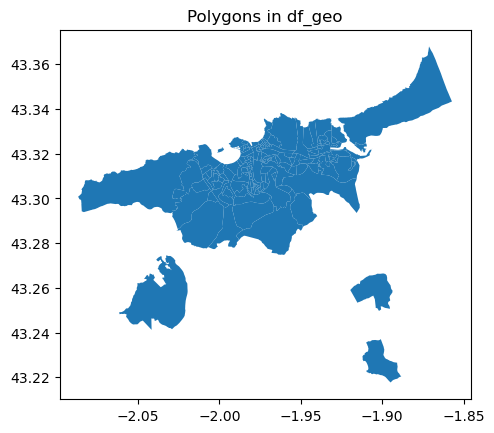

In [43]:


# Plot the polygons
df_geo.plot()
plt.title("Polygons in df_geo")
plt.show()


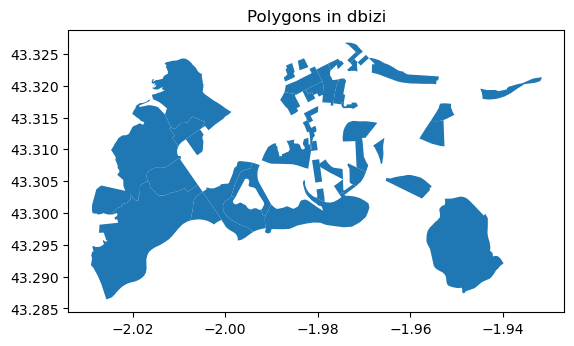

In [44]:
dbizi_sec = trips_gdf["Seccion"].unique()

#Plot the polygons for the sections in dbizi_sec

dbizi_geos = df_geo[df_geo["Seccion"].isin(dbizi_sec)]
dbizi_geos.plot()
plt.title("Polygons in dbizi")
plt.show()

In [45]:
trips_gdf.columns

Index(['ID', 'Estado cerrado', 'Duracion', 'Id de estacion de inicio',
       'Fecha de inicio', 'Nombre de estacion de inicio', 'Fecha de fin',
       'Id de estacion de fin de viaje', 'Nombre de estacion de fin de viaje',
       'ID de ciclista', 'Msnbc de bicicleta', 'Moto identificador publico',
       'Modelo de bicicleta', 'Nombre de producto', 'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'geometry', 'index_right', 'Seccion', 'Municipio',
       'Edad media de la población',
       'Porcentaje de población menor de 18 años',
       'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar',
       'Porcentaje de hogares unipersonales', 'Población',
       'Porcentaje de población española', 'Renta neta media por persona',
       'Renta neta media por hogar', 'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar'],
      dtype='object')

In [46]:
#Drop all afrer Seccion

trips_gdf = trips_gdf.drop(columns=[ 'Municipio',
       'Edad media de la población',
       'Porcentaje de población menor de 18 años',
       'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar',
       'Porcentaje de hogares unipersonales', 'Población',
       'Porcentaje de población española', 'Renta neta media por persona',
       'Renta neta media por hogar', 'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar','geometry','index_right'])

In [47]:
trips_gdf.head()


,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,Msnbc de bicicleta,Moto identificador publico,Modelo de bicicleta,Nombre de producto,start_lat,start_lon,end_lat,end_lon,Seccion
0,561067,NORMAL,3229,45,31/12/2021 23:44,45 - XABIER LIZARDI,01/01/2022 0:38,44.0,44 - BERNARDO ESTORNES,10995,P32359,771.0,EFIT,Ordinario,43.301378,-2.004624,43.303256,-2.007654,2006906023
1,561066,NORMAL,1384,6,31/12/2021 23:37,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,P32307,817.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005
2,561065,NORMAL,1452,6,31/12/2021 23:35,06 - ARRASATE,01/01/2022 0:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,P32331,705.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005
3,561064,GRACE_PERIOD,29,6,31/12/2021 23:35,06 - ARRASATE,31/12/2021 23:36,6.0,06 - ARRASATE,13634,P32409,793.0,EFIT,Ocasional,43.318323,-1.981554,43.318323,-1.981554,2006902005
4,561063,NORMAL,856,32,31/12/2021 23:31,32 - URBIA,31/12/2021 23:45,10.0,10 - PEÑA Y GOÑI,9877,P32390,777.0,EFIT,Ordinario,43.310841,-1.967488,43.322780,-1.977272,2006903021


In [48]:
trips_gdf['Fecha de inicio'] = pd.to_datetime(trips_gdf['Fecha de inicio'],dayfirst=True)
trips_gdf['Fecha de fin'] = pd.to_datetime(trips_gdf['Fecha de fin'], dayfirst=True)

#Extract day of the week from the start date
trips_gdf['day_of_week'] = trips_gdf['Fecha de inicio'].dt.day_name()

#Extract hour from the start date
trips_gdf['hour'] = trips_gdf['Fecha de inicio'].dt.hour

trips_gdf.head()

,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,...,Moto identificador publico,Modelo de bicicleta,Nombre de producto,start_lat,start_lon,end_lat,end_lon,Seccion,day_of_week,hour
0,561067,NORMAL,3229,45,2021-12-31 23:44:00,45 - XABIER LIZARDI,2022-01-01 00:38:00,44.0,44 - BERNARDO ESTORNES,10995,...,771.0,EFIT,Ordinario,43.301378,-2.004624,43.303256,-2.007654,2006906023,Friday,23
1,561066,NORMAL,1384,6,2021-12-31 23:37:00,06 - ARRASATE,2022-01-01 00:00:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,...,817.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005,Friday,23
2,561065,NORMAL,1452,6,2021-12-31 23:35:00,06 - ARRASATE,2022-01-01 00:00:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,...,705.0,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005,Friday,23
3,561064,GRACE_PERIOD,29,6,2021-12-31 23:35:00,06 - ARRASATE,2021-12-31 23:36:00,6.0,06 - ARRASATE,13634,...,793.0,EFIT,Ocasional,43.318323,-1.981554,43.318323,-1.981554,2006902005,Friday,23
4,561063,NORMAL,856,32,2021-12-31 23:31:00,32 - URBIA,2021-12-31 23:45:00,10.0,10 - PEÑA Y GOÑI,9877,...,777.0,EFIT,Ordinario,43.310841,-1.967488,43.322780,-1.977272,2006903021,Friday,23


In [49]:
#Rename secction to Seccion_init
trips_gdf = trips_gdf.rename(columns={"Seccion": "Seccion_init"})

# Extract the unique mapping from start points
start_points = trips_gdf.groupby(["start_lat", "start_lon", "Seccion_init"]).size().reset_index().drop(columns=0)

# Rename columns to match end station attributes
start_points = start_points.rename(columns={"start_lat": "end_lat", "start_lon": "end_lon", "Seccion_init": "Seccion_end"})

# Merge trips_gdf with the start_points mapping on end_lat and end_lon
trips_gdf = trips_gdf.merge(start_points, on=["end_lat", "end_lon"], how="left")



In [50]:
trips_gdf

,ID,Estado cerrado,Duracion,Id de estacion de inicio,Fecha de inicio,Nombre de estacion de inicio,Fecha de fin,Id de estacion de fin de viaje,Nombre de estacion de fin de viaje,ID de ciclista,...,Modelo de bicicleta,Nombre de producto,start_lat,start_lon,end_lat,end_lon,Seccion_init,day_of_week,hour,Seccion_end
0,561067,NORMAL,3229,45,2021-12-31 23:44:00,45 - XABIER LIZARDI,2022-01-01 00:38:00,44.0,44 - BERNARDO ESTORNES,10995,...,EFIT,Ordinario,43.301378,-2.004624,43.303256,-2.007654,2006906023,Friday,23,2006906030
1,561066,NORMAL,1384,6,2021-12-31 23:37:00,06 - ARRASATE,2022-01-01 00:00:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13634,...,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005,Friday,23,2006901002
2,561065,NORMAL,1452,6,2021-12-31 23:35:00,06 - ARRASATE,2022-01-01 00:00:00,47.0,01 - UDALETXEA / AYUNTAMIENTO,13635,...,EFIT,Ocasional,43.318323,-1.981554,43.321446,-1.986424,2006902005,Friday,23,2006901002
3,561064,GRACE_PERIOD,29,6,2021-12-31 23:35:00,06 - ARRASATE,2021-12-31 23:36:00,6.0,06 - ARRASATE,13634,...,EFIT,Ocasional,43.318323,-1.981554,43.318323,-1.981554,2006902005,Friday,23,2006902005
4,561063,NORMAL,856,32,2021-12-31 23:31:00,32 - URBIA,2021-12-31 23:45:00,10.0,10 - PEÑA Y GOÑI,9877,...,EFIT,Ordinario,43.310841,-1.967488,43.322780,-1.977272,2006903021,Friday,23,2006904003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275860,561072,NORMAL,2153,19,2022-01-01 00:12:00,19 - FRANTZIA PASEALEKUA,2022-01-01 00:48:00,20.0,20 - TABAKALERA,1362,...,FIT,Ordinario (promoción 25%),43.317646,-1.977400,43.317163,-1.974992,2006904001,Saturday,0,2006904010
1275861,561071,NORMAL,860,32,2022-01-01 00:09:00,32 - URBIA,2022-01-01 00:24:00,7.0,07 - MARQUÉS MIRAFLORES,1929,...,EFIT,Ordinario Grupal,43.310841,-1.967488,43.317033,-1.986010,2006903021,Saturday,0,2006902007
1275862,561070,NORMAL,362,52,2022-01-01 00:09:00,23 - GABRIEL CELAYA PLAZA,2022-01-01 00:15:00,21.0,21 - KARMENGO ANDRE MARIA / VIRGEN DEL CARMEN,12958,...,EFIT,Ordinario,43.316641,-1.953469,43.316996,-1.971482,2006907034,Saturday,0,2006904012
1275863,561069,NORMAL,238,19,2022-01-01 00:08:00,19 - FRANTZIA PASEALEKUA,2022-01-01 00:12:00,15.0,15 - SEGUNDO IZPIZUA,7123,...,EFIT,Ordinario,43.317646,-1.977400,43.323948,-1.969948,2006904001,Saturday,0,2006905010


In [51]:
# Extract the date from the datetime column
trips_gdf['trip_date'] = trips_gdf['Fecha de inicio'].dt.date

# Group by date, day of week, hour, and sections
daily_trips = trips_gdf.groupby(
    ["trip_date", "day_of_week", "hour", "Seccion_init", "Seccion_end"]
).size().reset_index(name="num_trips_per_day")

# Calculate the average number of trips across days
avg_trips = daily_trips.groupby(
    ["day_of_week", "hour", "Seccion_init", "Seccion_end"]
)["num_trips_per_day"].mean().reset_index(name="avg_trips")

# Sort the results for readability
avg_trips = avg_trips.sort_values(
    by=["day_of_week", "hour", "Seccion_init", "Seccion_end"], ascending=True
)

# Display the result
print(avg_trips.head())


  day_of_week  hour Seccion_init Seccion_end  avg_trips
0      Friday     0   2006901002  2006901002        1.0
1      Friday     0   2006901002  2006902007        1.0
2      Friday     0   2006901002  2006903013        1.0
3      Friday     0   2006901002  2006904003        1.0
4      Friday     0   2006901002  2006904012        1.0


In [52]:


# Unique values
days_of_week = trips_gdf['day_of_week'].unique()
print(days_of_week)
hours = trips_gdf['hour'].unique()
print(hours)
seccion_init = trips_gdf['Seccion_init'].unique()
seccion_end = trips_gdf['Seccion_end'].unique()
print(len(seccion_init), len(seccion_end))

# Create Cartesian product
all_combinations = pd.DataFrame(
    list(itertools.product(days_of_week, hours, seccion_init, seccion_end)),
    columns=["day_of_week", "hour", "Seccion_init", "Seccion_end"]
)


['Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday']
[23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
43 43


In [53]:
# Merge with observed trips
avg_trips_full = all_combinations.merge(
    avg_trips,
    on=["day_of_week", "hour", "Seccion_init", "Seccion_end"],
    how="left"
)

# Fill missing trip counts with zero
avg_trips_full["avg_trips"] = avg_trips_full["avg_trips"].fillna(0)

# Sort for readability
avg_trips_full = avg_trips_full.sort_values(
    by=["day_of_week", "hour", "Seccion_init", "Seccion_end"]
)


# Define stratification column
avg_trips_full["stratify_group"] = avg_trips_full["avg_trips"].apply(
    lambda x: 0 if x == 0 else (1 if x == 1 else 2)
)

# Inspect the result
print(avg_trips_full.head())


      day_of_week  hour Seccion_init Seccion_end  avg_trips  stratify_group
43130      Friday     0   2006901002  2006901002        1.0               1
43137      Friday     0   2006901002  2006901007        0.0               0
43155      Friday     0   2006901002  2006902002        0.0               0
43161      Friday     0   2006901002  2006902004        0.0               0
43131      Friday     0   2006901002  2006902005        0.0               0


In [54]:
avg_trips = avg_trips_full

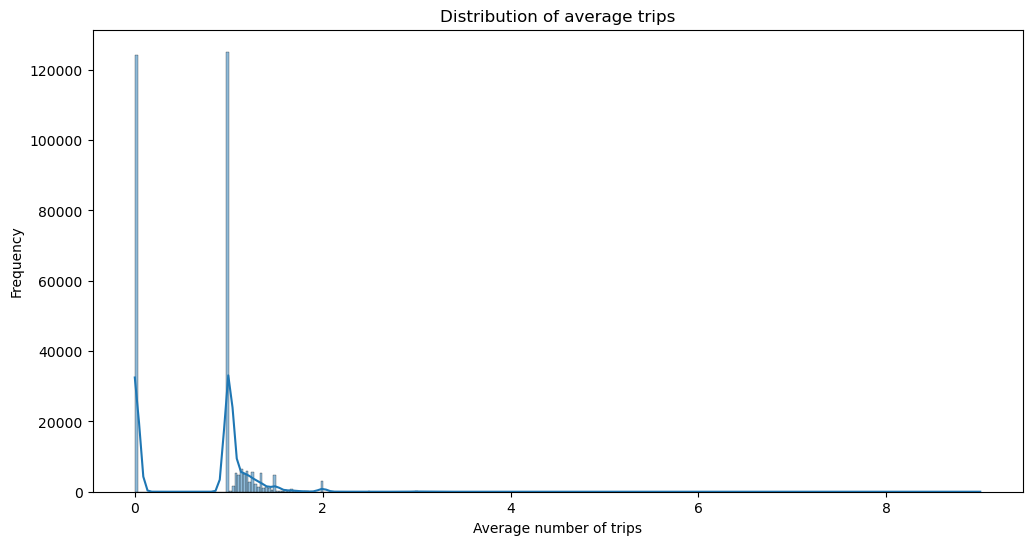

In [55]:
#plot distribution of avg trips

plt.figure(figsize=(12, 6))
sns.histplot(avg_trips["avg_trips"], kde=True)
plt.title("Distribution of average trips")
plt.xlabel("Average number of trips")
plt.ylabel("Frequency")
plt.show()


In [56]:
avg_trips.describe()



,hour,avg_trips,stratify_group
count,310632.000000,310632.000000,310632.000000
mean,11.500000,0.660702,0.798018
std,6.922198,0.564096,0.745858
min,0.000000,0.000000,0.000000
25%,5.750000,0.000000,0.000000
50%,11.500000,1.000000,1.000000
75%,17.250000,1.000000,1.000000
max,23.000000,9.000000,2.000000


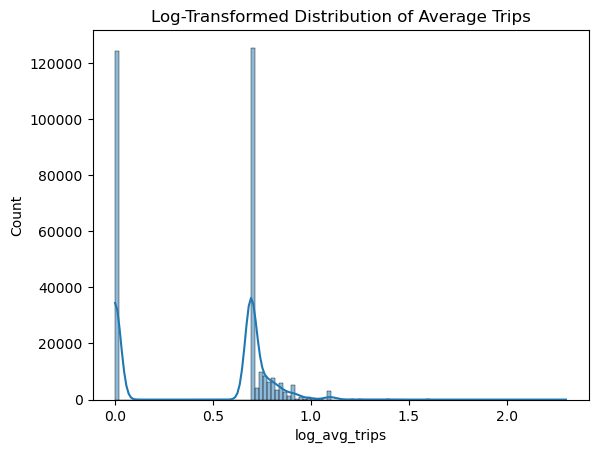

In [57]:
# Apply log transformation
avg_trips["log_avg_trips"] = np.log1p(avg_trips["avg_trips"])  # log(1 + x)

# Check the new distribution
sns.histplot(avg_trips["log_avg_trips"], kde=True)
plt.title("Log-Transformed Distribution of Average Trips")
plt.show()


In [58]:
#Scale log avg trips by 100

avg_trips["log_avg_trips"] = avg_trips["log_avg_trips"] * 100

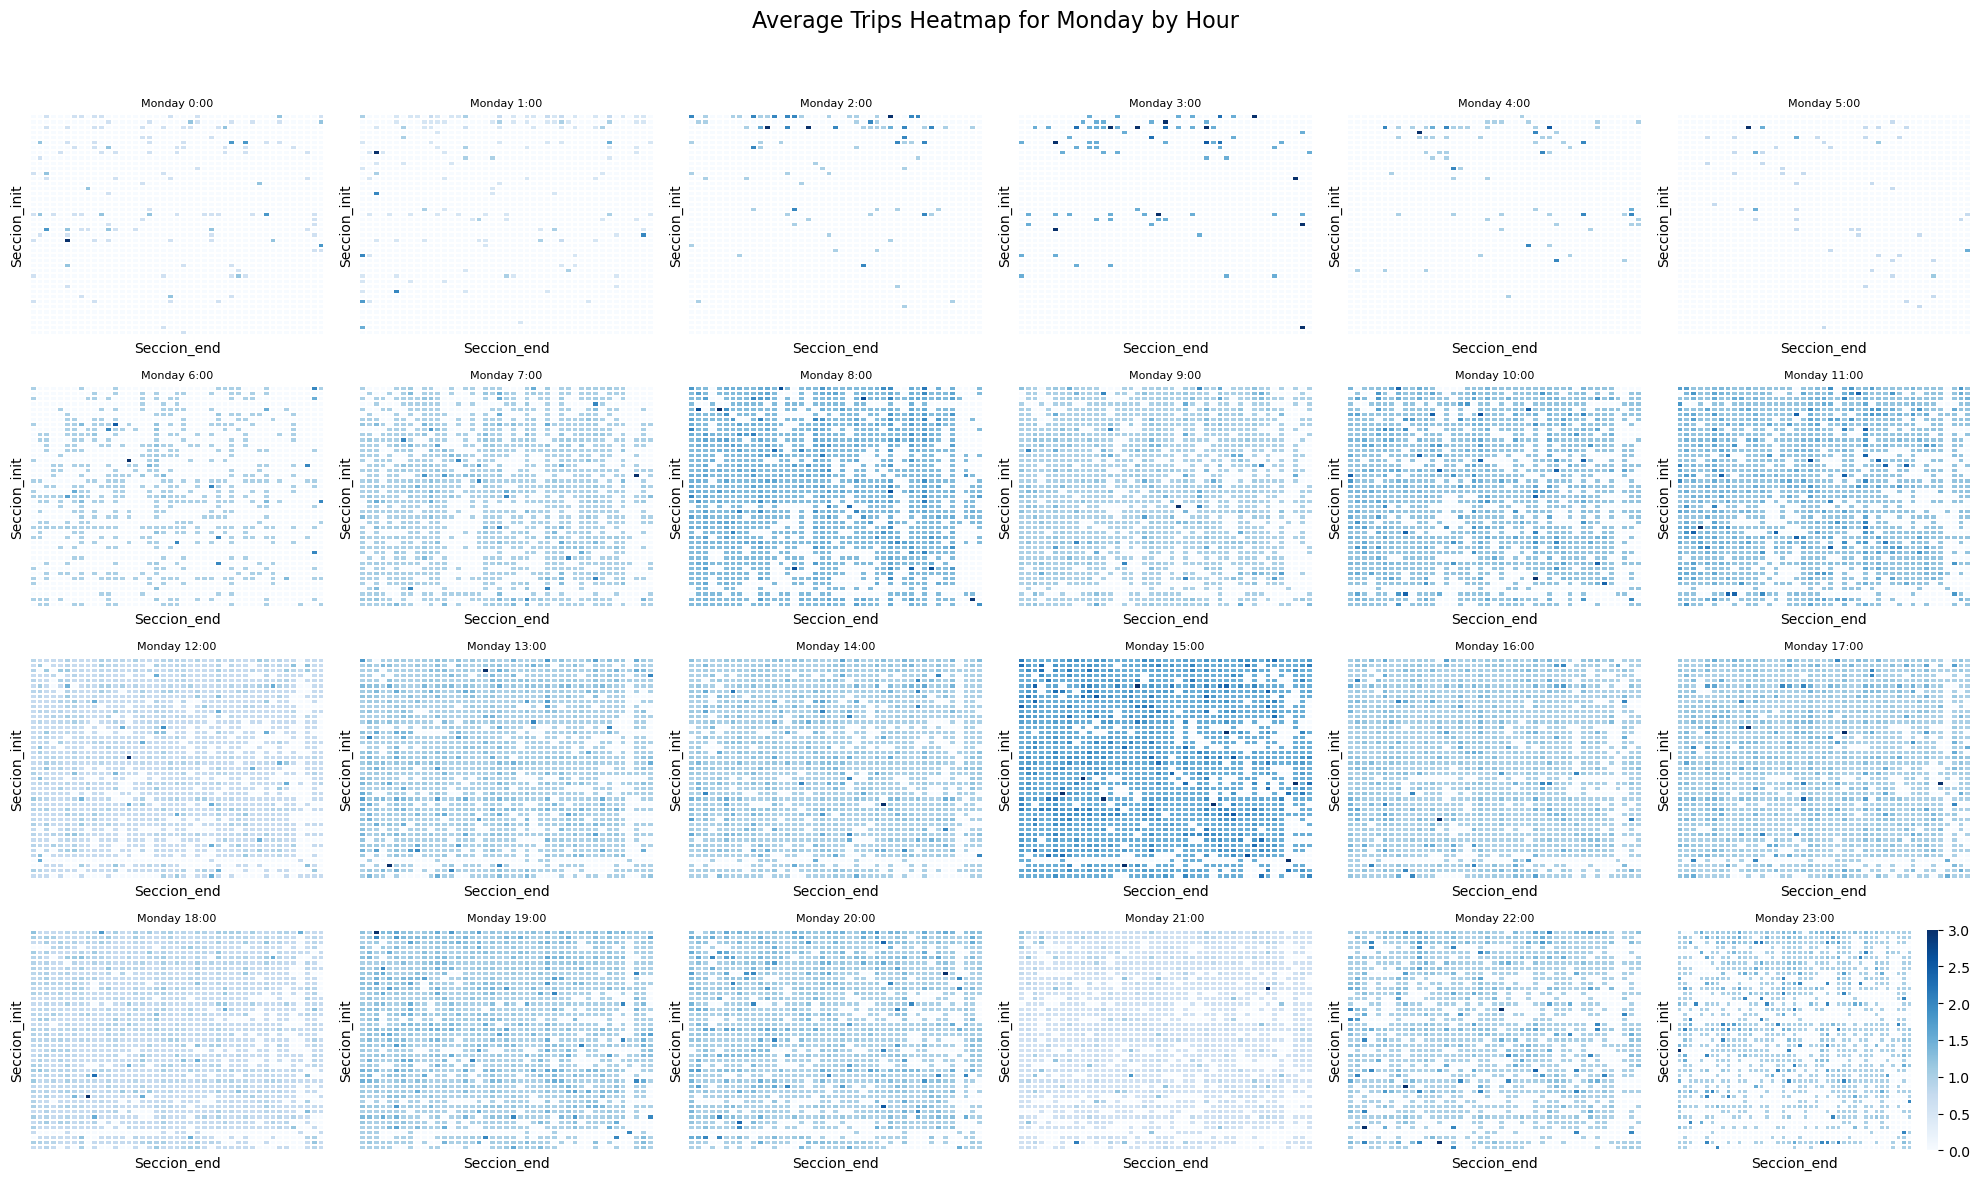

In [59]:
# Choose one weekday, e.g., "Monday"
selected_day = "Monday"

# Filter the data for the selected day
filtered_data = avg_trips[avg_trips['day_of_week'] == selected_day]

# Set up a figure with subplots for each hour
fig, axes = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each hour and plot a heatmap
for hour in range(24):
    ax = axes[hour]
    
    # Filter data for the current hour
    hour_data = filtered_data[filtered_data['hour'] == hour]
    
    if hour_data.empty:
        ax.set_title(f"{selected_day} {hour}:00 (No Data)", fontsize=8)
        ax.axis('off')  # Hide empty plots
        continue
    
    # Pivot the data for heatmap
    heatmap_data = hour_data.pivot(
        index="Seccion_init", 
        columns="Seccion_end", 
        values="avg_trips"
    )

    # Plot the heatmap
    sns.heatmap(
        heatmap_data, 
        ax=ax, 
        cmap="Blues", 
        cbar=(hour == 23),  # Show colorbar only on the last plot
        vmin=0, vmax=heatmap_data.max().max(),
        linewidths=0.1
    )
    ax.set_title(f"{selected_day} {hour}:00", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Final layout adjustments
fig.suptitle(f"Average Trips Heatmap for {selected_day} by Hour", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [60]:
land_uses.shape

(482, 28)

In [61]:
#Add land use data to df_geo
df_geo = df_geo.merge(land_uses, on="Seccion", how="left")
df_geo.head()

,Seccion,Municipio,geometry,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,...,Accesos y,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,index_righ,Renta_medi
0,2006401001,Pasaia,"MULTIPOLYGON (((-1.85711 43.34337, -1.85779 43...",48.1,13.4,26.5,2.2,37.2,796.0,93.7,...,0,3843,0,423,1116,687,1245,0,27690.0,1986790.0
1,2006401002,Pasaia,"MULTIPOLYGON (((-1.90936 43.32325, -1.90946 43...",46.8,16.4,26.1,2.4,29.2,1361.0,92.6,...,13,0,0,0,0,5718,0,0,12626.0,848243.0
2,2006402001,Pasaia,"MULTIPOLYGON (((-1.92481 43.32480, -1.92580 43...",47.5,13.0,22.7,2.1,42.0,746.0,94.3,...,15,1465,1500,148,775,132,918,0,16555.0,1339800.0
3,2006402002,Pasaia,"MULTIPOLYGON (((-1.92796 43.32395, -1.92809 43...",44.7,17.1,21.8,2.2,39.1,651.0,89.1,...,0,0,0,0,0,0,0,0,8856.0,560142.0
4,2006402003,Pasaia,"MULTIPOLYGON (((-1.92731 43.32513, -1.92738 43...",45.5,15.1,22.4,2.4,28.7,702.0,89.8,...,0,787,0,728,0,0,0,0,8029.0,489843.0


In [62]:
df_geo.columns

Index(['Seccion', 'Municipio', 'geometry', 'Edad media de la población',
       'Porcentaje de población menor de 18 años',
       'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar',
       'Porcentaje de hogares unipersonales', 'Población',
       'Porcentaje de población española', 'Renta neta media por persona',
       'Renta neta media por hogar', 'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar', 'Town',
       'Edificabil', 'Solar', 'Vivienda', 'Trastero', 'Garaje Cer',
       'Agropecuar', 'Local Come', 'Industrial', 'Almacen', 'Deportivo',
       'Cultural', 'Educativo', 'Oficina', 'Hosteleria', 'Obras Urba',
       'Altura men', 'Terraza', 'Accesos y', 'Jardin', 'Sanidad', 'Deposito',
       'Duplex', 'Plaza Park', 'Religioso', 'Espectacul', 'index_righ',
       'Renta_medi'],
      dtype='object')

In [63]:
avg_trips

,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips
43130,Friday,0,2006901002,2006901002,1.0,1,69.314718
43137,Friday,0,2006901002,2006901007,0.0,0,0.000000
43155,Friday,0,2006901002,2006902002,0.0,0,0.000000
43161,Friday,0,2006901002,2006902004,0.0,0,0.000000
43131,Friday,0,2006901002,2006902005,0.0,0,0.000000
...,...,...,...,...,...,...,...
90472,Wednesday,23,2006907034,2006906030,0.0,0,0.000000
90514,Wednesday,23,2006907034,2006907008,1.0,1,69.314718
90513,Wednesday,23,2006907034,2006907027,0.0,0,0.000000
90499,Wednesday,23,2006907034,2006907033,1.0,1,69.314718


In [64]:
df_geo["Seccion"].nunique()

158

In [65]:
#Number of stations per seccion

# Covert the trips to geo dataframes
geometry = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]  # Longitude first!
stations_gdf = gpd.GeoDataFrame(stations, geometry=geometry, crs="EPSG:4326")  # WGS84 CRS


#Find Seccion for station
stations_gdf = gpd.sjoin(stations_gdf, sections, op="within")

#Group by CUSEC and count the number of stations

stations_per_seccion = stations_gdf.groupby("CUSEC").size().reset_index(name="num_stations")
# Rename cusec to Seccion
stations_per_seccion = stations_per_seccion.rename(columns={"CUSEC": "Seccion"})
stations_per_seccion.head()

/Users/naroacorettisanchez/anaconda3/envs/ml/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Seccion,num_stations
0,2006901002,1
1,2006901007,1
2,2006902002,2
3,2006902004,1
4,2006902005,1


In [66]:
#Merge stations_per_seccion with df_geo

df_geo = df_geo.merge(stations_per_seccion, on="Seccion", how="left")
df_geo.head()

,Seccion,Municipio,geometry,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,...,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,index_righ,Renta_medi,num_stations
0,2006401001,Pasaia,"MULTIPOLYGON (((-1.85711 43.34337, -1.85779 43...",48.1,13.4,26.5,2.2,37.2,796.0,93.7,...,3843,0,423,1116,687,1245,0,27690.0,1986790.0,NaN
1,2006401002,Pasaia,"MULTIPOLYGON (((-1.90936 43.32325, -1.90946 43...",46.8,16.4,26.1,2.4,29.2,1361.0,92.6,...,0,0,0,0,5718,0,0,12626.0,848243.0,NaN
2,2006402001,Pasaia,"MULTIPOLYGON (((-1.92481 43.32480, -1.92580 43...",47.5,13.0,22.7,2.1,42.0,746.0,94.3,...,1465,1500,148,775,132,918,0,16555.0,1339800.0,NaN
3,2006402002,Pasaia,"MULTIPOLYGON (((-1.92796 43.32395, -1.92809 43...",44.7,17.1,21.8,2.2,39.1,651.0,89.1,...,0,0,0,0,0,0,0,8856.0,560142.0,NaN
4,2006402003,Pasaia,"MULTIPOLYGON (((-1.92731 43.32513, -1.92738 43...",45.5,15.1,22.4,2.4,28.7,702.0,89.8,...,787,0,728,0,0,0,0,8029.0,489843.0,NaN


In [67]:
#For num_stations fill the NaN with 0

df_geo["num_stations"] = df_geo["num_stations"].fillna(0)
df_geo.head()

,Seccion,Municipio,geometry,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,Tamaño medio del hogar,Porcentaje de hogares unipersonales,Población,Porcentaje de población española,...,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,index_righ,Renta_medi,num_stations
0,2006401001,Pasaia,"MULTIPOLYGON (((-1.85711 43.34337, -1.85779 43...",48.1,13.4,26.5,2.2,37.2,796.0,93.7,...,3843,0,423,1116,687,1245,0,27690.0,1986790.0,0.0
1,2006401002,Pasaia,"MULTIPOLYGON (((-1.90936 43.32325, -1.90946 43...",46.8,16.4,26.1,2.4,29.2,1361.0,92.6,...,0,0,0,0,5718,0,0,12626.0,848243.0,0.0
2,2006402001,Pasaia,"MULTIPOLYGON (((-1.92481 43.32480, -1.92580 43...",47.5,13.0,22.7,2.1,42.0,746.0,94.3,...,1465,1500,148,775,132,918,0,16555.0,1339800.0,0.0
3,2006402002,Pasaia,"MULTIPOLYGON (((-1.92796 43.32395, -1.92809 43...",44.7,17.1,21.8,2.2,39.1,651.0,89.1,...,0,0,0,0,0,0,0,8856.0,560142.0,0.0
4,2006402003,Pasaia,"MULTIPOLYGON (((-1.92731 43.32513, -1.92738 43...",45.5,15.1,22.4,2.4,28.7,702.0,89.8,...,787,0,728,0,0,0,0,8029.0,489843.0,0.0


In [68]:
#Add attributes of the Seccion_init and Seccion_end to avg_trips

# Add the attributes of the start section
avg_trips = avg_trips.merge(
    df_geo, 
    left_on="Seccion_init", 
    right_on="Seccion", 
    suffixes=("", "_start"), 
    how="left"
).drop(columns=["Seccion"])  # Drop after first merge

# Add the attributes of the end section
avg_trips = avg_trips.merge(
    df_geo, 
    left_on="Seccion_end", 
    right_on="Seccion", 
    suffixes=("", "_end"), 
    how="left"
)

# Inspect the result
avg_trips.head()

,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips,Municipio,geometry,Edad media de la población,...,Jardin_end,Sanidad_end,Deposito_end,Duplex_end,Plaza Park_end,Religioso_end,Espectacul_end,index_righ_end,Renta_medi_end,num_stations_end
0,Friday,0,2006901002,2006901002,1.0,1,69.314718,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,0,0,0,46,0,0,3205,14672.0,1076488.0,1.0
1,Friday,0,2006901002,2006901007,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,0,0,0,828,409,0,0,13832.0,884260.0,1.0
2,Friday,0,2006901002,2006902002,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,0,77,0,2974,75,3895,2500,31088.0,3525704.0,2.0
3,Friday,0,2006901002,2006902004,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,0,0,0,986,3183,0,0,15602.0,1613850.0,1.0
4,Friday,0,2006901002,2006902005,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,0,0,0,396,0,0,0,15660.0,1410386.0,1.0


In [69]:
avg_trips.columns

Index(['day_of_week', 'hour', 'Seccion_init', 'Seccion_end', 'avg_trips',
       'stratify_group', 'log_avg_trips', 'Municipio', 'geometry',
       'Edad media de la población',
       'Porcentaje de población menor de 18 años',
       'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar',
       'Porcentaje de hogares unipersonales', 'Población',
       'Porcentaje de población española', 'Renta neta media por persona',
       'Renta neta media por hogar', 'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Renta bruta media por persona', 'Renta bruta media por hogar', 'Town',
       'Edificabil', 'Solar', 'Vivienda', 'Trastero', 'Garaje Cer',
       'Agropecuar', 'Local Come', 'Industrial', 'Almacen', 'Deportivo',
       'Cultural', 'Educativo', 'Oficina', 'Hosteleria', 'Obras Urba',
       'Altura men', 'Terraza', 'Accesos y', 'Jardin', 'Sanidad', 'Deposito',
       'Duplex', 'Plaza Park', 'Religioso', 'Espectacul', '

# Add geospatial data

In [70]:
#Keep only rows where CUSEC is in df_geo

sections = sections[sections["CUSEC"].isin(df_geo["Seccion"])]
#Rename CUSEC to Seccion
sections = sections.rename(columns={"CUSEC": "Seccion"})

sections.head()

,Seccion,CUMUN,Seccion,Distrito,CUDIS,Municipio,geometry
250,2006401001,20064,001,01,2006401,Pasaia,"MULTIPOLYGON (((-1.85711 43.34337, -1.85779 43..."
251,2006401002,20064,002,01,2006401,Pasaia,"MULTIPOLYGON (((-1.90936 43.32325, -1.90946 43..."
252,2006402001,20064,001,02,2006402,Pasaia,"MULTIPOLYGON (((-1.92481 43.32480, -1.92580 43..."
253,2006402002,20064,002,02,2006402,Pasaia,"MULTIPOLYGON (((-1.92796 43.32395, -1.92809 43..."
254,2006402003,20064,003,02,2006402,Pasaia,"MULTIPOLYGON (((-1.92731 43.32513, -1.92738 43..."


In [71]:

# Reproject sections for accurate area and centroid calculations
sections_projected = sections.to_crs(epsg=25830)  # UTM 30N for Spain

# Calculate centroids in projected CRS (meters)
sections_projected["centroid"] = sections_projected.geometry.centroid

# Reproject back to WGS84 for geographic coordinates
sections_projected = sections_projected.set_geometry("centroid").to_crs(epsg=4326)
sections_projected["lat"] = sections_projected.geometry.y
sections_projected["lon"] = sections_projected.geometry.x

# Correctly extract centroids from reprojected GeoDataFrame
coords = sections_projected[["lat", "lon"]].values

# Create a spatial search tree using BallTree
tree = BallTree(np.radians(coords), metric="haversine")

# Find neighbors within 1 km (Earth radius ~6371 km)
sections_projected["neighbor_count"] = [
    len(tree.query_radius([np.radians(coord)], r=1.0 / 6371.0)[0]) - 1 for coord in coords
]


# Calculate area in square meters
sections_projected["area_m2"] = sections_projected["geometry"].area

# Inspect result
sections_projected.head()


,Seccion,CUMUN,Seccion,Distrito,CUDIS,Municipio,geometry,centroid,lat,lon,neighbor_count,area_m2
250,2006401001,20064,001,01,2006401,Pasaia,"MULTIPOLYGON (((592635.377 4799580.415, 592580...",POINT (-1.88806 43.34214),43.342141,-1.888058,0,8.981008e+06
251,2006401002,20064,002,01,2006401,Pasaia,"MULTIPOLYGON (((588428.873 4797290.111, 588421...",POINT (-1.91280 43.32306),43.323060,-1.912800,2,1.464171e+05
252,2006402001,20064,001,02,2006402,Pasaia,"MULTIPOLYGON (((587174.239 4797445.653, 587093...",POINT (-1.92696 43.32856),43.328564,-1.926965,10,3.988402e+05
253,2006402002,20064,002,02,2006402,Pasaia,"MULTIPOLYGON (((586920.249 4797347.661, 586909...",POINT (-1.92897 43.32435),43.324347,-1.928966,17,2.909555e+04
254,2006402003,20064,003,02,2006402,Pasaia,"MULTIPOLYGON (((586971.373 4797479.158, 586965...",POINT (-1.92956 43.32597),43.325971,-1.929562,15,7.029203e+04


In [72]:
#Sum all the m2 and convert to km2
total_area = sections_projected["area_m2"].sum() / 1e6
total_area

71.67470575128509

Looks good because m2 for SS is around 60

In [73]:

# Drop the second occurrence of "Seccion"
sections_projected = sections_projected.loc[:, ~sections_projected.columns.duplicated()]



In [74]:
# For avg trips, add the lat and lon of the start and end sections, as well as the area and neighbor count

# Add the attributes of the start section
avg_trips = avg_trips.merge(
    sections_projected[["Seccion", "lat", "lon", "area_m2", "neighbor_count"]],
    left_on="Seccion_init",
    right_on="Seccion",
    suffixes=("", "_start"),
    how="left"
)

# Add the attributes of the end section
avg_trips = avg_trips.merge(
    sections_projected[["Seccion", "lat", "lon", "area_m2", "neighbor_count"]],
    left_on="Seccion_end",
    right_on="Seccion",
    suffixes=("", "_end"),
    how="left"
)

# Inspect the result
avg_trips.head()

,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips,Municipio,geometry,Edad media de la población,...,Seccion_start,lat,lon,area_m2,neighbor_count,Seccion_end,lat_end,lon_end,area_m2_end,neighbor_count_end
0,Friday,0,2006901002,2006901002,1.0,1,69.314718,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,2006901002,43.322083,-1.986070,37376.328258,25
1,Friday,0,2006901002,2006901007,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,2006901007,43.323360,-1.983289,23743.953781,30
2,Friday,0,2006901002,2006902002,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,2006902002,43.320458,-1.982938,138955.040346,36
3,Friday,0,2006901002,2006902004,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,2006902004,43.319429,-1.980258,45965.176671,46
4,Friday,0,2006901002,2006902005,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,2006902005,43.318381,-1.981922,23971.840235,38


In [75]:
# Haversine formula function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate the distance and store it
avg_trips['distance_km'] = haversine(
    avg_trips['lat'], avg_trips['lon'], 
    avg_trips['lat_end'], avg_trips['lon_end']
)

# Inspect the result
avg_trips.head()

,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips,Municipio,geometry,Edad media de la población,...,lat,lon,area_m2,neighbor_count,Seccion_end,lat_end,lon_end,area_m2_end,neighbor_count_end,distance_km
0,Friday,0,2006901002,2006901002,1.0,1,69.314718,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,43.322083,-1.98607,37376.328258,25,2006901002,43.322083,-1.986070,37376.328258,25,0.000000
1,Friday,0,2006901002,2006901007,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,43.322083,-1.98607,37376.328258,25,2006901007,43.323360,-1.983289,23743.953781,30,0.266084
2,Friday,0,2006901002,2006902002,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,43.322083,-1.98607,37376.328258,25,2006902002,43.320458,-1.982938,138955.040346,36,0.311187
3,Friday,0,2006901002,2006902004,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,43.322083,-1.98607,37376.328258,25,2006902004,43.319429,-1.980258,45965.176671,46,0.555109
4,Friday,0,2006901002,2006902005,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,43.322083,-1.98607,37376.328258,25,2006902005,43.318381,-1.981922,23971.840235,38,0.531137


In [76]:
list(avg_trips.columns)

['day_of_week',
 'hour',
 'Seccion_init',
 'Seccion_end',
 'avg_trips',
 'stratify_group',
 'log_avg_trips',
 'Municipio',
 'geometry',
 'Edad media de la población',
 'Porcentaje de población menor de 18 años',
 'Porcentaje de población de 65 y más años',
 'Tamaño medio del hogar',
 'Porcentaje de hogares unipersonales',
 'Población',
 'Porcentaje de población española',
 'Renta neta media por persona',
 'Renta neta media por hogar',
 'Media de la renta por unidad de consumo',
 'Mediana de la renta por unidad de consumo',
 'Renta bruta media por persona',
 'Renta bruta media por hogar',
 'Town',
 'Edificabil',
 'Solar',
 'Vivienda',
 'Trastero',
 'Garaje Cer',
 'Agropecuar',
 'Local Come',
 'Industrial',
 'Almacen',
 'Deportivo',
 'Cultural',
 'Educativo',
 'Oficina',
 'Hosteleria',
 'Obras Urba',
 'Altura men',
 'Terraza',
 'Accesos y',
 'Jardin',
 'Sanidad',
 'Deposito',
 'Duplex',
 'Plaza Park',
 'Religioso',
 'Espectacul',
 'index_righ',
 'Renta_medi',
 'num_stations',
 'Seccion',

In [77]:
#Drop Town, Town_end, index_righ, index_righ_end, Seccion, Municipio_end, geometry_end, second instance of Seccion_end

avg_trips = avg_trips.drop(columns=["Town", "Town_end", "index_righ", "index_righ_end", "Seccion", "Municipio_end", "geometry_end"])

avg_trips = avg_trips.loc[:, ~avg_trips.columns.duplicated(keep='first')]

# Inspect the updated DataFrame
avg_trips.head()



,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips,Municipio,geometry,Edad media de la población,...,Seccion_start,lat,lon,area_m2,neighbor_count,lat_end,lon_end,area_m2_end,neighbor_count_end,distance_km
0,Friday,0,2006901002,2006901002,1.0,1,69.314718,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,43.322083,-1.986070,37376.328258,25,0.000000
1,Friday,0,2006901002,2006901007,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,43.323360,-1.983289,23743.953781,30,0.266084
2,Friday,0,2006901002,2006902002,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,43.320458,-1.982938,138955.040346,36,0.311187
3,Friday,0,2006901002,2006902004,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,43.319429,-1.980258,45965.176671,46,0.555109
4,Friday,0,2006901002,2006902005,0.0,0,0.000000,Donostia/San Sebastián,"MULTIPOLYGON (((-1.98499 43.32216, -1.98518 43...",46.9,...,2006901002,43.322083,-1.98607,37376.328258,25,43.318381,-1.981922,23971.840235,38,0.531137


In [78]:
#Drop geometry, Municipio
avg_trips = avg_trips.drop(columns=["geometry", "Municipio"])




In [79]:
#Recode the day of the week to numbers

day_of_week_mapping = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}

# Map the day of the week to numbers
avg_trips["day_of_week"] = avg_trips["day_of_week"].map(day_of_week_mapping)

# Drop lat and long cols
avg_trips = avg_trips.drop(columns=["lat", "lon", "lat_end", "lon_end"])

In [80]:
list(avg_trips.columns)

['day_of_week',
 'hour',
 'Seccion_init',
 'Seccion_end',
 'avg_trips',
 'stratify_group',
 'log_avg_trips',
 'Edad media de la población',
 'Porcentaje de población menor de 18 años',
 'Porcentaje de población de 65 y más años',
 'Tamaño medio del hogar',
 'Porcentaje de hogares unipersonales',
 'Población',
 'Porcentaje de población española',
 'Renta neta media por persona',
 'Renta neta media por hogar',
 'Media de la renta por unidad de consumo',
 'Mediana de la renta por unidad de consumo',
 'Renta bruta media por persona',
 'Renta bruta media por hogar',
 'Edificabil',
 'Solar',
 'Vivienda',
 'Trastero',
 'Garaje Cer',
 'Agropecuar',
 'Local Come',
 'Industrial',
 'Almacen',
 'Deportivo',
 'Cultural',
 'Educativo',
 'Oficina',
 'Hosteleria',
 'Obras Urba',
 'Altura men',
 'Terraza',
 'Accesos y',
 'Jardin',
 'Sanidad',
 'Deposito',
 'Duplex',
 'Plaza Park',
 'Religioso',
 'Espectacul',
 'Renta_medi',
 'num_stations',
 'Edad media de la población_end',
 'Porcentaje de población m

In [81]:
#Show column names for non numeric cols
avg_trips.select_dtypes(exclude=['float64', 'int64']).columns


Index(['hour', 'Seccion_init', 'Seccion_end',
       'Media de la renta por unidad de consumo',
       'Mediana de la renta por unidad de consumo',
       'Media de la renta por unidad de consumo_end',
       'Mediana de la renta por unidad de consumo_end', 'Seccion_start'],
      dtype='object')

In [82]:
#Seccio init and Seccion start to numeric
avg_trips["Seccion_init"] = avg_trips["Seccion_init"].astype(int)
avg_trips["Seccion_start"] = avg_trips["Seccion_start"].astype(int)
avg_trips["Seccion_end"] = avg_trips["Seccion_end"].astype(int)


#Convert hour to numeric
avg_trips["hour"] = avg_trips["hour"].astype(int)



#Mediana de la renta por unidad de consumo to numeric
avg_trips["Mediana de la renta por unidad de consumo"] = avg_trips["Mediana de la renta por unidad de consumo"].astype(float)
avg_trips["Mediana de la renta por unidad de consumo_end"] = avg_trips["Mediana de la renta por unidad de consumo_end"].astype(float)
avg_trips["Media de la renta por unidad de consumo"] = avg_trips["Media de la renta por unidad de consumo"].astype(float)
avg_trips["Media de la renta por unidad de consumo_end"] = avg_trips["Media de la renta por unidad de consumo_end"].astype(float)



In [84]:


#Make copies of 'hour', 'Seccion_init', 'Seccion_end', 'num_stations' , 'num_stations_end' for later use
avg_trips["hour_c"] = avg_trips["hour"].copy()
avg_trips["Seccion_init_c"] = avg_trips["Seccion_init"].copy()
avg_trips["Seccion_end_c"] = avg_trips["Seccion_end"].copy()
avg_trips["num_stations_c"] = avg_trips["num_stations"].copy()
avg_trips["num_stations_end_c"] = avg_trips["num_stations_end"].copy()

# Select numeric features for scaling
numeric_features = avg_trips.select_dtypes(include=['float64', 'int64']).columns


#Exculde avg_trips and log_avg_trips, and day_of_week
numeric_features = numeric_features.drop(["avg_trips", "log_avg_trips", "day_of_week",'hour_c', 'Seccion_init_c', 'Seccion_end_c', 'num_stations_c', 'num_stations_end_c'])


# Initialize scaler
scaler = RobustScaler()

# Apply Robust Scaling
avg_trips[numeric_features] = scaler.fit_transform(avg_trips[numeric_features])


In [85]:
avg_trips.describe()

,day_of_week,hour,Seccion_init,Seccion_end,avg_trips,stratify_group,log_avg_trips,Edad media de la población,Porcentaje de población menor de 18 años,Porcentaje de población de 65 y más años,...,area_m2,neighbor_count,area_m2_end,neighbor_count_end,distance_km,hour_c,Seccion_init_c,Seccion_end_c,num_stations_c,num_stations_end_c
count,310632.000000,3.106320e+05,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,...,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,310632.000000,3.106320e+05,3.106320e+05,310632.000000,310632.000000
mean,4.000000,-1.463942e-17,0.117107,0.117107,0.660702,-0.201982,44.306201,-0.201827,0.288601,-0.109256,...,1.030670,-0.073812,1.030670,-0.073812,0.065195,11.500000,2.006904e+09,2.006904e+09,1.209302,1.209302
std,2.000003,6.019302e-01,0.579055,0.579055,0.564096,0.745858,36.773241,0.803942,0.823941,0.573094,...,2.668079,0.576694,2.668079,0.576694,0.729495,6.922198,1.741220e+03,1.741220e+03,0.460442,0.460442
min,1.000000,-1.000000e+00,-1.000998,-1.000998,0.000000,-1.000000,0.000000,-2.089286,-0.754098,-1.154362,...,-0.425053,-1.130435,-0.425053,-1.130435,-1.177165,0.000000,2.006901e+09,2.006901e+09,1.000000,1.000000
25%,2.000000,-5.000000e-01,-0.332225,-0.332225,0.000000,-1.000000,0.000000,-0.625000,-0.311475,-0.657718,...,-0.308260,-0.608696,-0.308260,-0.608696,-0.490865,5.750000,2.006903e+09,2.006903e+09,1.000000,1.000000
50%,4.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,69.314718,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,2.006904e+09,2.006904e+09,1.000000,1.000000
75%,6.000000,5.000000e-01,0.667775,0.667775,1.000000,0.000000,69.314718,0.375000,0.688525,0.342282,...,0.691740,0.391304,0.691740,0.391304,0.509135,17.250000,2.006906e+09,2.006906e+09,1.000000,1.000000
max,7.000000,1.000000e+00,1.004988,1.004988,9.000000,1.000000,230.258509,0.910714,3.131148,1.060403,...,11.762436,0.869565,11.762436,0.869565,2.935925,23.000000,2.006907e+09,2.006907e+09,3.000000,3.000000


In [ ]:
if False:

    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        verbose=2
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    print("Best RMSE from CV:", -grid_search.best_score_)

In [ ]:
#best_model = grid_search.best_estimator_
#print(best_model)    

In [86]:
#learning rate 0.1, max_depth 7, n_estimators 300, subsample 0.8


#Save all cols as feactures except avg_trips
#features = avg_trips.columns.difference(["avg_trips"])
#target = "avg_trips"
features = avg_trips.columns.difference(["avg_trips","log_avg_trips","weights","stratify_group",'hour_c', 'Seccion_init_c', 'Seccion_end_c', 'num_stations_c', 'num_stations_end_c'])
target = "log_avg_trips"

data = avg_trips
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, subsample=0.8, max_depth=7, random_state=42)
xgb_model.fit(X_train, y_train, )

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 23.25686265229781
R² Score: 0.60145693467783


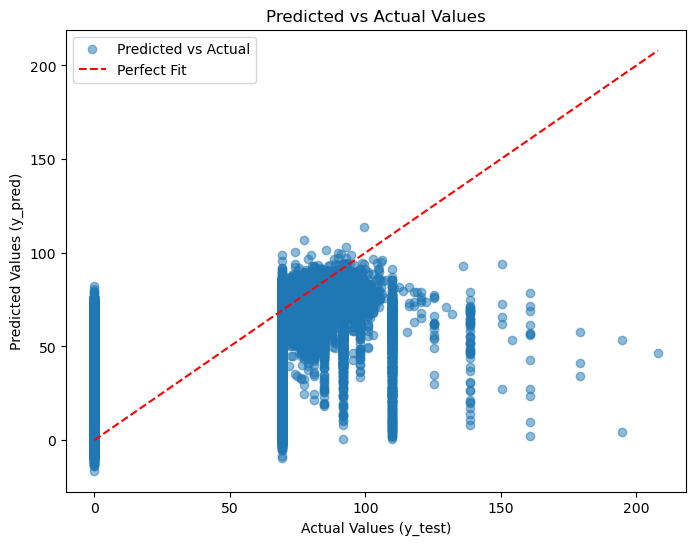

In [87]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()


In [88]:
# Create buckets for actual and predicted values
y_test_buckets = pd.Series(y_test.values, index=y_test.index).apply(
    lambda x: 0 if x == 0 else (1 if x == 1 else 2)
)
y_pred_buckets = pd.Series(y_pred, index=y_test.index).apply(
    lambda x: 0 if x < 0.5 else (1 if x < 1.5 else 2)
)

# Calculate classification-like accuracy
from sklearn.metrics import accuracy_score
classification_accuracy = accuracy_score(y_test_buckets, y_pred_buckets)

print(f"Classification-like Accuracy (Buckets): {classification_accuracy * 100:.2f}%")


Classification-like Accuracy (Buckets): 67.97%


In [89]:


print(classification_report(y_test_buckets, y_pred_buckets, target_names=["Zero Trips", "One Trip", "> One Trip"]))


              precision    recall  f1-score   support

  Zero Trips       0.99      0.20      0.34     24928
    One Trip       0.00      0.00      0.00         0
  > One Trip       0.67      1.00      0.80     37199

    accuracy                           0.68     62127
   macro avg       0.55      0.40      0.38     62127
weighted avg       0.80      0.68      0.62     62127



/Users/naroacorettisanchez/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/naroacorettisanchez/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/naroacorettisanchez/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [90]:
#save the dataset 
avg_trips.to_csv("avg_trips_forprediction.csv", index=False)

